In [36]:
pip install gensim


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [134]:
glove_ids = {}
glove_vectors = {}
counter = 1

with open('glove.6B.100d.txt', 'r', encoding='utf-8') as file:
    for line in file:
        text = line.strip()
        glove_ids[text.split(' ')[0]] = counter
        glove_vectors[text.split(' ')[0]] = [float(x) for x in text.split(' ')[1:]]
        counter += 1


In [74]:
import pandas as pd
df = pd.read_csv('20ng.csv')
df['index'] = df['index'].str.replace(r'\d+$', '', regex=True)
classes = ["alt.atheism", "sci.med", "sci.electronics", "comp.graphics", "talk.politics.guns", "sci.crypt"]
df = df[df['index'].isin(classes)]

In [75]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['index'] = le.fit_transform(df['index'])


In [76]:
ng_text = df['content'].to_list()

In [90]:
from gensim.utils import simple_preprocess
import torch

def doc2ind(doc):
    words = simple_preprocess(doc)
    ind_arr = [0] * 2000
    counter = 0
    for word in range(len(words)):
        if counter >= 2000:
            break

        if words[word] in glove_ids:
            ind_arr[counter] = glove_ids[words[word]]
        counter += 1

    return ind_arr


In [91]:
from gensim.utils import simple_preprocess
import torch
tokens = list()
for text in ng_text:
    tokens.append(simple_preprocess(text))
ng_vector_idx = torch.LongTensor([doc2ind(doc) for doc in ng_text])

In [ ]:
glove_emb = torch.zeros((len(glove_ids) + 1, 100), dtype=torch.float32)
for word, idx in glove_ids.items():
    glove_emb[idx] = torch.tensor(glove_vectors[word], dtype=torch.float32)
glove_emb[0] = torch.zeros(100, dtype=torch.float32)  # padding index
glove_emb = nn.Embedding.from_pretrained(glove_emb, freeze=True)


In [155]:
ng_vector_idx_torch = torch.tensor(ng_vector_idx)
y_tensors = torch.tensor(df['index'].to_list())

C:\Users\ashwi\AppData\Local\Temp\ipykernel_28008\4237353396.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ng_vector_idx_torch = torch.tensor(ng_vector_idx)


In [156]:
y_tensors

tensor([0, 0, 0,  ..., 5, 5, 5])

In [157]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(ng_vector_idx_torch, y_tensors, test_size=0.2, random_state=42)

In [158]:
from torch.utils.data import TensorDataset

train = TensorDataset(X_train, y_train)
test = TensorDataset(X_test, y_test)

In [ ]:
def train_model(model, train_loader, criterion, optimizer, epochs):
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print('Epoch', str(epoch+1), '/', (str(epochs)), 'Loss: ', (total_loss/len(train_loader)))
    return model

In [160]:
def evaluate_model(model, test):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy

In [191]:
import torch.nn as nn

class NNet(nn.Module):
    def __init__(self, embedding, num_classes):
        super(NNet, self).__init__()
        self.embedding = embedding
        self.pool = nn.AdaptiveMaxPool1d(output_size=1)
        self.flatten = nn.Flatten(start_dim=1, end_dim=-1)
        self.fc1 = nn.Linear(embedding.embedding_dim, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, num_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.embedding(x)
        x = self.pool(x.permute(0, 2, 1)).squeeze()
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x





In [192]:
batch_size = 128

train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=False)   

number_of_classes = 6
epochs= 45

model = NNet(glove_emb, number_of_classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [193]:
glove_emb

Embedding(400001, 100)

In [194]:
trained_model = train_model(model, train_loader, criterion, optimizer, epochs)
accuracy = evaluate_model(trained_model, test_loader)
print('Accuracy', accuracy)

Epoch 1/45, Loss: 1.7894179287709688
Epoch 2/45, Loss: 1.7758406839872662
Epoch 3/45, Loss: 1.754602943596087
Epoch 4/45, Loss: 1.7203415726360523
Epoch 5/45, Loss: 1.680500472846784
Epoch 6/45, Loss: 1.6389878643186468
Epoch 7/45, Loss: 1.5944130922618664
Epoch 8/45, Loss: 1.5515568726941158
Epoch 9/45, Loss: 1.5085189028790122
Epoch 10/45, Loss: 1.467981994152069
Epoch 11/45, Loss: 1.4304934426357871
Epoch 12/45, Loss: 1.402357998647188
Epoch 13/45, Loss: 1.381721085623691
Epoch 14/45, Loss: 1.3532121338342364
Epoch 15/45, Loss: 1.3355795207776522
Epoch 16/45, Loss: 1.3260389409567181
Epoch 17/45, Loss: 1.307626275639785
Epoch 18/45, Loss: 1.2966859497522052
Epoch 19/45, Loss: 1.2866087461772717
Epoch 20/45, Loss: 1.2793890927967273
Epoch 21/45, Loss: 1.2697434362612272
Epoch 22/45, Loss: 1.263517925613805
Epoch 23/45, Loss: 1.2554362573121722
Epoch 24/45, Loss: 1.250747285391155
Epoch 25/45, Loss: 1.244652923784758
Epoch 26/45, Loss: 1.2423828118725826
Epoch 27/45, Loss: 1.240848945

In [201]:
def get_embedding(model, data_loader):
    model.eval()
    embeddings = []
    with torch.no_grad():
        for inputs, _ in data_loader:
            outputs = model.embedding(inputs)
            pooled = model.pool(outputs.permute(0, 2, 1)).squeeze()
            embeddings.append(pooled)
    return torch.cat(embeddings), torch.cat([labels for _, labels in data_loader])

In [202]:
final_embedding, labels = get_embedding(trained_model, test_loader)

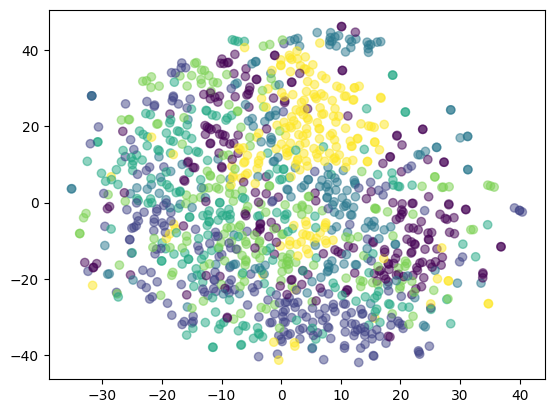

In [206]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(final_embedding)
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=labels, cmap='viridis', alpha=0.5)

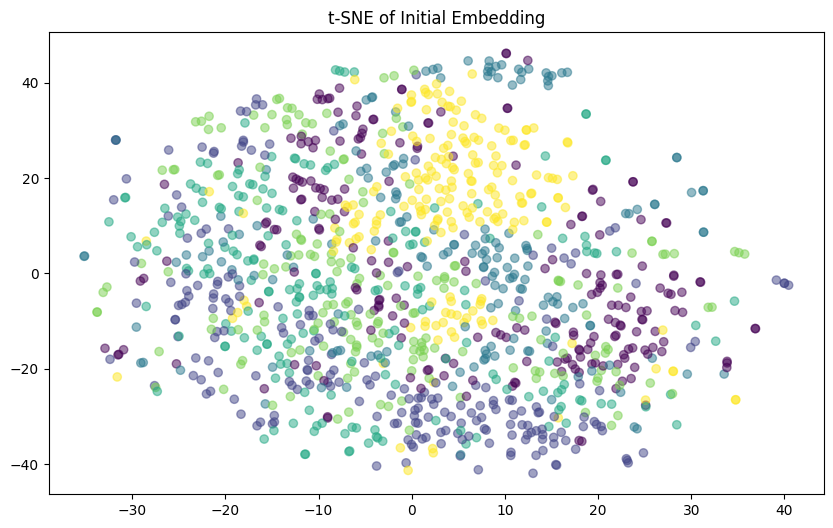

In [ ]:
initial_embedding, initial_labels = get_embedding(model, test_loader)

tsne_initial = TSNE(n_components=2, random_state=42)
tsne_initial_results = tsne_initial.fit_transform(initial_embedding)

plt.figure(figsize=(10, 6))
plt.scatter(tsne_initial_results[:, 0], tsne_initial_results[:, 1], c=initial_labels, cmap='viridis', alpha=0.5)
plt.title('t-SNE of Initial Embedding')
plt.show()

We can see close cluster for trained model whereas initial embeddings show more sparsed results.